In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch, Sbopen, VerticalPitch
from matplotlib.text import Text
from matplotlib.patches import Rectangle, Circle
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

# Get Euro 2024 games

In [5]:
parser = Sbopen()
df_games = parser.match(competition_id=55, season_id=282)
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 52 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   match_id                         51 non-null     int64         
 1   match_date                       51 non-null     datetime64[ns]
 2   kick_off                         51 non-null     datetime64[ns]
 3   home_score                       51 non-null     int64         
 4   away_score                       51 non-null     int64         
 5   match_status                     51 non-null     object        
 6   match_status_360                 51 non-null     object        
 7   last_updated                     51 non-null     datetime64[ns]
 8   last_updated_360                 51 non-null     datetime64[ns]
 9   match_week                       51 non-null     int64         
 10  competition_id                   51 non-null     int64         


# Get dribble events

In [6]:
def get_dribble_events(df):
    dribbles_mask = (df['type_name'] == 'Dribble')
    driblles_columns = ['match_id', 'period', 'minute', 'second', 'type_name', 'team_name', 'player_name', 'outcome_name', 'x', 'y']
    df_dribbles = df.loc[dribbles_mask, driblles_columns]
    
    return df_dribbles.reset_index(drop=True)

# Calculate playing time

To calculate playing time for a player, we need a couple of things:
- The length of each period (including extra time) in seconds

In [7]:
def get_period_lengths(df):
    df_end = df.loc[df['type_name'] == 'Half End', ['period', 'timestamp', 'minute', 'second', 'type_name', 'team_name']]
    df_periods = pd.DataFrame(columns=['period', 'length', 'additional_time', 'minutes_played', 'seconds_played', 'game_minute', 'game_second'])

    # Only check for first half, second half and extra time but not for penalties
    for period, total_length in [(1, 45), (2, 90), (3, 105), (4, 120)]:
        if period in df_end['period'].values:
            df_end_period = df_end.loc[df_end['period'] == period, ['timestamp', 'minute', 'second']].iloc[0]

            # Get played time of this period in minutes and seconds
            df_end_period['minutes_length'] = df_end_period['timestamp'].hour * 60 + df_end_period['timestamp'].minute
            df_end_period['seconds_length'] = df_end_period['timestamp'].second
            
            # Get period length and additional time in seconds
            period_length = df_end_period['minutes_length'] * 60 + df_end_period['seconds_length']
            period_additional_time = (df_end_period['minute'] * 60) + df_end_period['second'] - (total_length * 60)

            df_periods = pd.concat([
                df_periods,
                pd.DataFrame([{
                    'period': period,
                    'length': period_length,
                    'additional_time': period_additional_time,
                    'minutes_played': df_end_period['minutes_length'],
                    'seconds_played': df_end_period['seconds_length'],
                    'game_minute': df_end_period['minute'],
                    'game_second': df_end_period['second']
                }])
            ], ignore_index=True)
    return df_periods.reset_index(drop=True)


In [8]:
def get_substitution_events(df):
    subs_mask = (df['type_name'] == 'Substitution')
    subs_columns = ['match_id', 'period', 'minute', 'second', 'type_name', 'team_name', 'player_name', 'substitution_replacement_name']
    df_subs = df.loc[subs_mask, subs_columns]
    
    # rename the columns to be more descriptive about the substitution
    df_subs.rename(columns={
        'player_name': 'player_off',
        'substitution_replacement_name': 'player_on'
    }, inplace=True)
    
    return df_subs.reset_index(drop=True)

In [9]:
def get_red_card_events(df):
    red_card_names = ['Red Card', 'Second Yellow']

    # Init mask
    cards_mask = pd.Series(False, index=df.index)

    # Check each column if it exists and update mask
    if 'foul_committed_card_name' in df.columns:
        cards_mask = cards_mask | df['foul_committed_card_name'].isin(red_card_names)
    
    if 'bad_behaviour_card_name' in df.columns:
        cards_mask = cards_mask | df['bad_behaviour_card_name'].isin(red_card_names)
    
    # Add card columns that exist
    card_columns = ['match_id', 'period', 'minute', 'second', 'type_name', 'team_name', 'player_name']
    if 'foul_committed_card_name' in df.columns:
        card_columns.append('foul_committed_card_name')
    if 'bad_behaviour_card_name' in df.columns:
        card_columns.append('bad_behaviour_card_name')
    
    df_cards = df[cards_mask][card_columns]
    
    return df_cards.reset_index(drop=True)

In [10]:
def get_playing_time_df(df_periods, df_dribbles, df_subs, df_reds):
    # Calculate total game time of match
    full_game_time = df_periods['length'].sum()
        
    # Get players who made dribbles and init the playing time df
    df_playing_time = df_dribbles[['match_id', 'player_name', 'team_name']].drop_duplicates()
    df_playing_time['playing_time'] = full_game_time

    # Adapt playing time for players who were substituted
    for i, player in df_playing_time.iterrows():
        player_name = player['player_name']
        player_playing_time = player['playing_time']
        
        # If player came on, how much time did they miss from the start of the game?
        if player_name in df_subs['player_on'].values:
            sub_on = df_subs[df_subs['player_on'] == player_name]
            period = sub_on['period'].values[0]
            minute = sub_on['minute'].values[0]
            second = sub_on['second'].values[0]
            missed_playing_time = minute * 60 + second

            # loop through df_periods to add extra time to missed_playing_time from all periods before the sub
            for i, row in df_periods.iterrows():
                if row['period'] < period:
                    missed_playing_time += row['additional_time']
                else:
                    break

            total_playing_time = player_playing_time - missed_playing_time
            
            df_playing_time.loc[df_playing_time['player_name'] == player_name, 'playing_time'] = total_playing_time
        
        # If player came off, how much time did they miss to the end of the game?
        if player_name in df_subs['player_off'].values:
            sub_off = df_subs[df_subs['player_off'] == player_name]
            period = sub_off['period'].values[0]
            minute = sub_off['minute'].values[0]
            second = sub_off['second'].values[0]

            playing_time_before_sub = minute * 60 + second
            missed_playing_time = full_game_time - playing_time_before_sub

            # loop through df_periods to add extra time to missed_playing_time from all periods after the sub
            for i, row in df_periods.iterrows():
                if row['period'] >= period and row['period'] < 4:
                    missed_playing_time += row['additional_time']
                else:
                    continue
            
            total_playing_time = player_playing_time - missed_playing_time
            
            df_playing_time.loc[df_playing_time['player_name'] == player_name, 'playing_time'] = total_playing_time
        
        # If player came off with a red card, how much time did they miss to the end of the game?
        if player_name in df_reds['player_name'].values:
            red_card_off = df_reds[df_reds['player_name'] == player_name]
            period = red_card_off['period'].values[0]
            minute = red_card_off['minute'].values[0]
            second = red_card_off['second'].values[0]

            playing_time_before_red_card = minute * 60 + second
            missed_playing_time = full_game_time - playing_time_before_red_card

            # loop through df_periods to add extra time to missed_playing_time from all periods after the red card
            for i, row in df_periods.iterrows():
                if row['period'] >= period and row['period'] < 4:
                    missed_playing_time += row['additional_time']
                else:
                    continue
            
            total_playing_time = player_playing_time - missed_playing_time
            
            df_playing_time.loc[df_playing_time['player_name'] == player_name, 'playing_time'] = total_playing_time

    return df_playing_time.reset_index(drop=True)

In [ ]:
# Test game with extra time
extra_time_mask = (df_games['home_team_country_name'] == 'England')
df_england = df_games.loc[extra_time_mask, ['match_id', 'match_date', 'home_score', 'away_score', 'home_team_name', 'away_team_name', 'competition_stage_name', 'match_status']]
df_england.head(10)

match_id = 3942227
df_test_extra_time = parser.event(match_id)[0]

# Get period times
df_periods = get_period_lengths(df_test_extra_time)
full_game_time = df_periods['length'].sum()
print(f"Full game time: {full_game_time} seconds")
df_periods.head(10)

# # Get dribbles
# df_dribble_events = get_dribble_events(df_test_extra_time)
# df_dribble_events.head()

# # Get substitutions
# df_substitution_events = get_substitution_events(df_test_extra_time)
# df_substitution_events.head(15)

# # Get red cards
# df_red_card_events = get_red_card_events(df_test_extra_time)
# df_red_card_events.head(15)

# # Get playing time
# df_playing_time = get_playing_time_df(df_periods, df_dribble_events, df_substitution_events, df_red_card_events)
# df_playing_time.head(10)

Full game time: 7449 seconds


,period,length,additional_time,minutes_played,seconds_played,game_minute,game_second
0,1,2706,6,45,6,45,6
1,2,2876,176,47,56,92,56
2,3,900,0,15,0,105,0
3,4,967,67,16,7,121,7


In [144]:
# Test game with red card

# All red card matches
# red_card_match_id = 3930158
# red_card_match_id = 3942226
# red_card_match_id = 3930184
red_card_match_id = 3942382

df_red_card = parser.event(red_card_match_id)[0]

df_red_card_events = get_red_card_events(df_red_card)
df_red_card_events.head(15)

,match_id,period,minute,second,type_name,team_name,player_name,foul_committed_card_name,bad_behaviour_card_name
0,3942382,2,95,21,Bad Behaviour,Turkey,Bertuğ Özgür Yıldırım,NaN,Red Card


In [145]:
# Create empty dribbles and playing time dataframes
df_dribbles = pd.DataFrame()
df_playing_time = pd.DataFrame()

# Loop through matches
for match_id in df_games['match_id']:
    df = parser.event(match_id)[0]

    # Get period times
    df_periods = get_period_lengths(df)
    full_game_time = df_periods['length'].sum()
    # print(f"Full game time: {full_game_time} seconds")
    df_periods.head(10)

    # Get dribbles
    df_dribble_events = get_dribble_events(df)
    df_dribble_events.head()

    # Get substitutions
    df_substitution_events = get_substitution_events(df)
    df_substitution_events.head(15)

    # Get red cards
    df_red_card_events = get_red_card_events(df)
    df_red_card_events.head(15)

    # Get playing time
    df_players = get_playing_time_df(df_periods, df_dribble_events, df_substitution_events, df_red_card_events)
    df_players.head(10)

    df_dribbles = pd.concat([df_dribbles, df_dribble_events], ignore_index=True)
    df_playing_time = pd.concat([df_playing_time, df_players], ignore_index=True)

In [146]:
df_dribbles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   match_id      1280 non-null   int64  
 1   period        1280 non-null   int64  
 2   minute        1280 non-null   int64  
 3   second        1280 non-null   int64  
 4   type_name     1280 non-null   object 
 5   team_name     1280 non-null   object 
 6   player_name   1280 non-null   object 
 7   outcome_name  1280 non-null   object 
 8   x             1280 non-null   float64
 9   y             1280 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 100.1+ KB


In [147]:
df_playing_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   match_id      645 non-null    int64 
 1   player_name   645 non-null    object
 2   team_name     645 non-null    object
 3   playing_time  645 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 20.3+ KB


In [148]:
df_dribbles.head(100)

,match_id,period,minute,second,type_name,team_name,player_name,outcome_name,x,y
0,3942819,1,1,44,Dribble,England,Kyle Walker,Complete,47.3,59.4
1,3942819,1,3,16,Dribble,England,Phil Foden,Incomplete,74.2,28.6
2,3942819,1,8,5,Dribble,England,Jude Bellingham,Incomplete,99.0,23.9
3,3942819,1,40,23,Dribble,Netherlands,Cody Mathès Gakpo,Incomplete,30.9,36.7
4,3942819,1,46,46,Dribble,Netherlands,Denzel Dumfries,Incomplete,100.4,74.5
...,...,...,...,...,...,...,...,...,...,...
95,3942349,1,40,19,Dribble,France,Randal Kolo Muani,Incomplete,27.9,55.3
96,3942349,1,43,31,Dribble,Portugal,Bruno Miguel Borges Fernandes,Incomplete,63.5,4.8
97,3942349,2,49,41,Dribble,Portugal,Nuno Mendes,Complete,91.6,4.4
98,3942349,2,50,11,Dribble,France,Kylian Mbappé Lottin,Incomplete,97.7,18.0


In [149]:
# Create player stats: combine dribble stats and playing time

# Get dribble stats per player
dribble_stats = df_dribbles.groupby(['player_name', 'team_name', 'outcome_name']).size().unstack(fill_value=0)
dribble_stats = dribble_stats.rename(columns={'Complete': 'complete_dribbles', 'Incomplete': 'incomplete_dribbles'})
dribble_stats = dribble_stats.reset_index()
dribble_stats.columns.name = None

# Get playing time stats per player
playing_time_stats = df_playing_time.groupby(['player_name', 'team_name'])['playing_time'].sum().reset_index()
playing_time_stats['minutes_played'] = (playing_time_stats['playing_time'] / 60).round(2)

# Merge the two DataFrames into player stats
df_player_stats = pd.merge(dribble_stats, playing_time_stats, on=['player_name', 'team_name'], how='left')

# Calculate extra dribble stats
df_player_stats['total_dribbles'] = df_player_stats['complete_dribbles'] + df_player_stats['incomplete_dribbles']
df_player_stats['dribbles_per_90'] = ((df_player_stats['total_dribbles'] / (df_player_stats['playing_time'])) * 5400).round(2)
df_player_stats['dribble_success_rate'] = ((df_player_stats['complete_dribbles'] / df_player_stats['total_dribbles']) * 100).round(2)

# Filter out players with less than 10 dribbles
df_player_stats = df_player_stats[df_player_stats['total_dribbles'] >= 10]

# Sort player stats
df_player_stats = df_player_stats.sort_values('dribbles_per_90', ascending=False).reset_index(drop=True)
df_player_stats.head(50)

,player_name,team_name,playing_time,minutes_played,complete_dribbles,incomplete_dribbles,total_dribbles,dribbles_per_90,dribble_success_rate
0,Jeremy Doku,Belgium,18580,309.67,15,12,27,7.85,55.56
1,Khvicha Kvaratskhelia,Georgia,20808,346.80,14,14,28,7.27,50.00
2,Donyell Malen,Netherlands,8800,146.67,7,4,11,6.75,63.64
3,Nicholas Williams Arthuer,Spain,29135,485.58,15,17,32,5.93,46.88
4,Ousmane Dembélé,France,20339,338.98,14,8,22,5.84,63.64
5,Kylian Mbappé Lottin,France,28544,475.73,18,10,28,5.30,64.29
6,Federico Chiesa,Italy,13374,222.90,7,6,13,5.25,53.85
7,Leroy Sané,Germany,12432,207.20,6,6,12,5.21,50.00
8,Lamine Yamal Nasraoui Ebana,Spain,29594,493.23,12,15,27,4.93,44.44
9,Georges Mikautadze,Georgia,21176,352.93,8,11,19,4.85,42.11


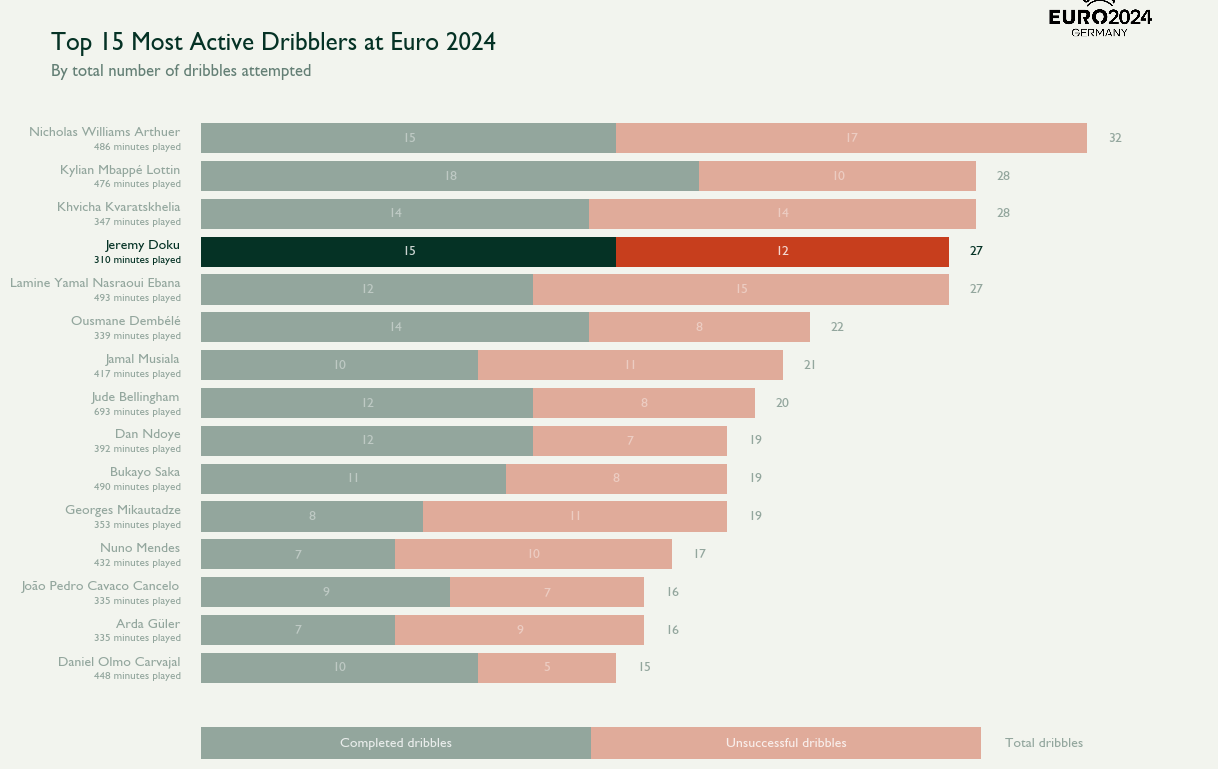

In [150]:
# Sort players by total dribbles and completed dribbles
df_top_dribblers_total = df_player_stats.sort_values(['total_dribbles', 'complete_dribbles'], ascending=True).tail(15)

# Reset the index after sorting
df_top_dribblers_total = df_top_dribblers_total.reset_index(drop=True)

# Variables
background_color = "#f2f4ee"
dark_color = "#053225"
green_color = "#053225"
red_color = "#C73E1D"

# Init plot
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor(background_color)
ax.set_facecolor(background_color)
plt.rcParams['font.family'] = 'Gill Sans'
plt.rcParams.update({
    'text.color': dark_color,
    'axes.labelcolor': dark_color,
    'axes.edgecolor': dark_color,
    'xtick.color': dark_color,
    'ytick.color': dark_color,
    'grid.color': dark_color,
})

# Set titles
plt.suptitle('Top 15 Most Active Dribblers at Euro 2024', fontweight='bold', fontsize=18, ha='left', x=0, y=0.96)
plt.text(0, 0.9, 'By total number of dribbles attempted', ha='left', va='bottom', transform=plt.gcf().transFigure, fontsize=12, color=dark_color, alpha=0.6)

# Define legend dimensions and position
legend_width = 0.65
rect_height = 0.04
y_position = 0.05  # Position from bottom
x_start = 0.125      # Starting position from left

# Create rectangles for legend
complete_rect = Rectangle((x_start, y_position), legend_width/2, rect_height, 
                        facecolor=green_color, alpha=0.4, transform=fig.transFigure)
incomplete_rect = Rectangle((x_start + legend_width/2, y_position), legend_width/2, rect_height, 
                          facecolor=red_color, alpha=0.4, transform=fig.transFigure)

# Add rectangles to figure
fig.add_artist(complete_rect)
fig.add_artist(incomplete_rect)

# Add text inside rectangles (centered)
plt.figtext(x_start + legend_width/4, y_position + rect_height/2, 'Completed dribbles', 
            ha='center', va='center', fontsize=10, color='white', fontweight='bold', alpha=0.8)
plt.figtext(x_start + 3*legend_width/4, y_position + rect_height/2, 'Unsuccessful dribbles', 
            ha='center', va='center', fontsize=10, color='white', fontweight='bold', alpha=0.8)

# Add total label
plt.figtext(x_start + legend_width + 0.02, y_position + rect_height/2, 'Total dribbles', 
            ha='left', va='center', fontsize=10, fontweight='bold', alpha=0.4)


# Loop through data and plot different things
for i, row in df_top_dribblers_total.iterrows():
    # Check if player is Jeremy Doku and set opacity accordingly
    player = row['player_name']
    alpha = 1.0 if player == 'Jeremy Doku' else 0.4

    # Plot complete/incomplete dribbles
    ax.barh(
        player,
        row['complete_dribbles'],
        color=green_color,
        alpha=alpha
    )
    ax.barh(
        player,
        row['incomplete_dribbles'],
        color=red_color,
        left=row['complete_dribbles'],
        alpha=alpha
    )

    # Plot total number of dribbles
    total = row['total_dribbles']
    plt.text(total + 0.75, i, str(int(total)), va='center', fontweight='bold', alpha=alpha)

    # Plot custom player labels
    ax.text(-0.75, i,
            f"{row['player_name']}", 
            ha='right',
            va='bottom',
            fontsize=10,
            fontweight='bold',
            alpha=alpha)
    ax.text(-0.75, i - 0.1,
            f"{row['minutes_played']:.0f} minutes played", 
            ha='right',
            va='top',
            fontsize=8,
            color=dark_color,
            alpha=alpha)
            
# Add annotations for complete and incomplete dribbles
for i, v in enumerate(df_top_dribblers_total['complete_dribbles']):
    # Check if player is Doku
    player = df_top_dribblers_total.iloc[i]['player_name']
    alpha = 0.8 if player == 'Jeremy Doku' else 0.4
    ax.text(v/2, i, str(v), 
            color='white',
            alpha=alpha,
            va='center',
            ha='center',
            fontweight='bold')
for i, v in enumerate(df_top_dribblers_total['incomplete_dribbles']):
    # Check if player is Doku
    player = df_top_dribblers_total.iloc[i]['player_name']
    alpha = 0.8 if player == 'Jeremy Doku' else 0.4
    ax.text(v/2 + df_top_dribblers_total['complete_dribbles'].iloc[i], i, str(v), 
            color='white',
            alpha=alpha,
            va='center',
            ha='center',
            fontweight='bold')

# Remove labels and ticks
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticks([])

# Remove all spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add Euros 2024 logo
logo = mpimg.imread('euro_2024_logo.png')
imagebox = OffsetImage(logo, zoom=0.15)  # Adjust zoom factor as needed
ab = AnnotationBbox(imagebox, 
                    xy=(0.96, 0.98),      # Position in axes coordinates (x, y)
                    xycoords='figure fraction',
                    box_alignment=(1, 1),  # Alignment of box (1,1 is top right)
                    frameon=False)        # No frame around the image

fig.add_artist(ab)

# Adjust layout and margins
plt.savefig('total_dribbles.png', 
            bbox_inches='tight',
            pad_inches=0.5,  # Adjust this value to control the padding
            facecolor=background_color,
            dpi=300)
plt.show()

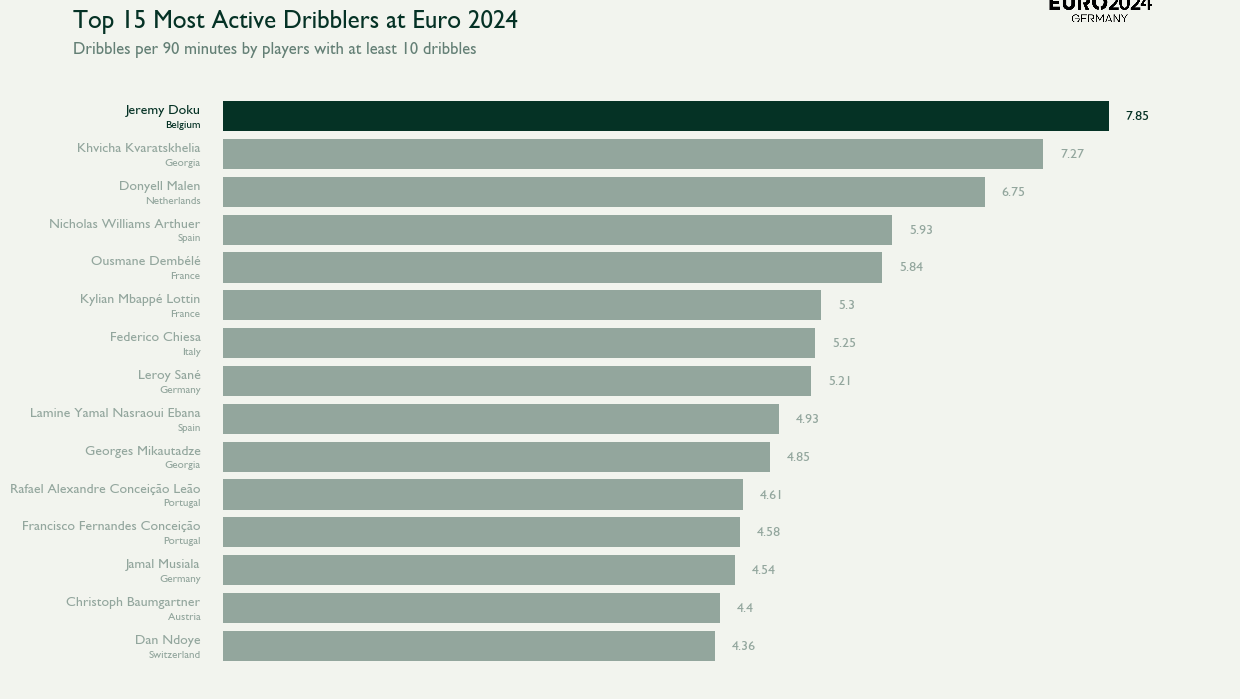

In [151]:
# Sort players by dribbles per 90 minutes
df_top_dribblers_per_90 = df_player_stats.sort_values('dribbles_per_90', ascending=True).tail(15)

# Reset the index after sorting
df_top_dribblers_per_90 = df_top_dribblers_per_90.reset_index(drop=True)

# Variables
background_color = "#f2f4ee"
dark_color = "#053225"

# Init plot
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor(background_color)
ax.set_facecolor(background_color)
plt.rcParams['font.family'] = 'Gill Sans'
plt.rcParams.update({
    'text.color': dark_color,
    'axes.labelcolor': dark_color,
    'axes.edgecolor': dark_color,
    'xtick.color': dark_color,
    'ytick.color': dark_color,
    'grid.color': dark_color,
})

# Set titles
plt.suptitle('Top 15 Most Active Dribblers at Euro 2024', fontweight='bold', fontsize=18, ha='left', x=0, y=0.96)
plt.text(0, 0.9, 'Dribbles per 90 minutes by players with at least 10 dribbles', ha='left', va='bottom', transform=plt.gcf().transFigure, fontsize=12, color=dark_color, alpha=0.6)

# Loop through data and plot different things
for i, row in df_top_dribblers_per_90.iterrows():
    # Check if player is Jeremy Doku and set opacity accordingly
    player = row['player_name']
    alpha = 1.0 if player == 'Jeremy Doku' else 0.4 

    # Per 90 bar
    ax.barh(
        player,
        row['dribbles_per_90'],
        color=dark_color,
        alpha=alpha
    )
    
    # Per 90 number
    per_90 = row['dribbles_per_90']
    plt.text(per_90 + 0.15, i, per_90, va='center', fontweight='bold', alpha=alpha, color=dark_color)

    # Player name in bold
    ax.text(-0.2, i,
            f"{row['player_name']}", 
            ha='right',
            va='bottom',
            fontsize=10,
            fontweight='bold',
            alpha=alpha)
    
    # Team name in smaller, lighter font
    ax.text(-0.2, i - 0.1,
            f"{row['team_name']}", 
            ha='right',
            va='top',
            fontsize=8,
            alpha=alpha)
    

# Remove labels and ticks
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticks([])

# Remove all spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add Euros 2024 logo (moved to correct position on saved image, looks different here)
logo = mpimg.imread('euro_2024_logo.png')
imagebox = OffsetImage(logo, zoom=0.15)  # Adjust zoom factor as needed
ab = AnnotationBbox(imagebox, 
                    xy=(0.96, 0.91),      # Position in axes coordinates (x, y)
                    xycoords='figure fraction',
                    box_alignment=(1, 1),  # Alignment of box (1,1 is top right)
                    frameon=False)        # No frame around the image

fig.add_artist(ab)

# Adjust layout and margins
plt.savefig('dribbles_per_90.png', 
            bbox_inches='tight',
            pad_inches=0.4,  # Adjust this value to control the padding
            facecolor=background_color,
            dpi=300)
plt.show()

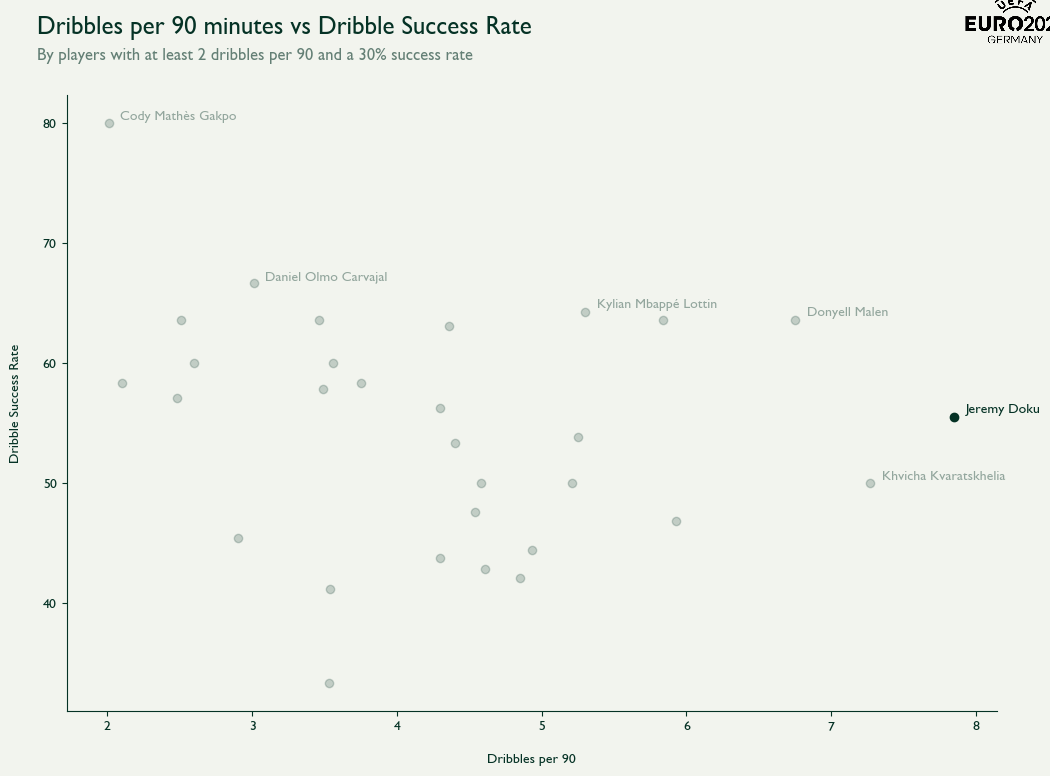

In [152]:
# Filter out players with less than 2 dribbles per 90 and less than 30% success rate
df_filtered = df_player_stats[(df_player_stats['dribbles_per_90'] >= 2) & (df_player_stats['dribble_success_rate'] >= 30)]

# Variables
background_color = "#f2f4ee"
dark_color = "#053225"

# Init plot
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor(background_color)
ax.set_facecolor(background_color)
plt.rcParams['font.family'] = 'Gill Sans'
plt.rcParams.update({
    'text.color': dark_color,
    'axes.labelcolor': dark_color,
    'axes.edgecolor': dark_color,
    'xtick.color': dark_color,
    'ytick.color': dark_color,
    'grid.color': dark_color,
})

# Set titles and labels
plt.suptitle('Dribbles per 90 minutes vs Dribble Success Rate', fontweight='bold', fontsize=18, ha='left', x=0.1, y=0.98)
plt.text(0.1, 0.92, 'By players with at least 2 dribbles per 90 and a 30% success rate', ha='left', va='bottom', transform=plt.gcf().transFigure, fontsize=12, color=dark_color, alpha=0.6)
plt.xlabel('Dribbles per 90', labelpad=15)
plt.ylabel('Dribble Success Rate', labelpad=15)

# Scatter plot of dribbles per 90 and dribble success rate
for i, row in df_filtered.iterrows():
    alpha = 1.0 if row['player_name'] == 'Jeremy Doku' else 0.2
    plt.scatter(row['dribbles_per_90'], row['dribble_success_rate'], color=dark_color, alpha=alpha)

# Get important players: top 3 per 90 and top 3 per success rate
df_top_per_90 = df_filtered.sort_values('dribbles_per_90', ascending=False).head(3)
df_top_success_rate = df_filtered.sort_values('dribble_success_rate', ascending=False).head(3)

# Plot important player names
for i, row in df_top_per_90.iterrows():
    alpha = 1.0 if row['player_name'] == 'Jeremy Doku' else 0.4
    plt.text(x = row['dribbles_per_90'] + 0.08, y = row['dribble_success_rate'] + 0.3, s=row['player_name'], fontsize=10, alpha=alpha)

for i, row in df_top_success_rate.iterrows():
    alpha = 1.0 if row['player_name'] == 'Jeremy Doku' else 0.4
    plt.text(x = row['dribbles_per_90'] + 0.08, y = row['dribble_success_rate'] + 0.3, s=row['player_name'], fontsize=10, alpha=alpha)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add Euros 2024 logo
logo = mpimg.imread('euro_2024_logo.png')
imagebox = OffsetImage(logo, zoom=0.15)  # Adjust zoom factor as needed
ab = AnnotationBbox(imagebox, 
                    xy=(0.89, 0.98),      # Position in axes coordinates (x, y)
                    xycoords='figure fraction',
                    box_alignment=(1, 1),  # Alignment of box (1,1 is top right)
                    frameon=False)        # No frame around the image

fig.add_artist(ab)

# Adjust layout and margins
plt.savefig('per_90_v_success_rate.png', 
            bbox_inches='tight',
            pad_inches=0.5,  # Adjust this value to control the padding
            facecolor=background_color,
            dpi=300)

plt.show()

In [191]:
# Finding dribbles that ended in a shot
danger_dribbles = pd.DataFrame()

for match_id in df_games['match_id']:
    df = parser.event(match_id)[0]
    for period in [1, 2, 3, 4]:
        # Get successful dribbles
        mask_dribble = (df['type_name'] == 'Dribble') & (df['period'] == period) & (df['outcome_name'] == 'Complete')
        # Keep only necessary columns
        dribbles = df.loc[mask_dribble, ['match_id', 'period', 'minute', 'second', 'type_name', 'team_name', 'player_name', 'outcome_name', 'x', 'y']]

        # Get shots
        mask_shot = (df['type_name'] == 'Shot') & (df['period'] == period)
        shots = df.loc[mask_shot, ['match_id', 'period', 'minute', 'second', 'type_name', 'team_name', 'player_name', 'outcome_name', 'x', 'y']]

        # Set shot times
        shot_times = shots['minute'] * 60 + shots['second']
        shot_window = 15
        shot_start = shot_times - shot_window

        # Create period start times dictionary
        period_starts = {
            1: 0,          # First half: start at 0:00
            2: 45 * 60,    # Second half: start at 45:00
            3: 90 * 60,    # First ET: start at 90:00
            4: 105 * 60    # Second ET: start at 105:00
        }

        # Apply the adjustment using numpy where
        shot_start = np.where(shot_start < 0, 
                            [period_starts.get(p, 0) for p in shots['period']], 
                            shot_start)

        # Convert dribble times
        dribble_times = dribbles['minute'] * 60 + dribbles['second']

        # Filter dribbles within 15 seconds of a shot
        dribble_to_shot = dribble_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

        # Filter dribbles that ended in a shot
        danger_dribbles_period = dribbles.loc[dribble_to_shot]

        # Append to danger_dribbles
        danger_dribbles = pd.concat([danger_dribbles, danger_dribbles_period], ignore_index=True)
        
danger_dribbles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   match_id      146 non-null    int64  
 1   period        146 non-null    int64  
 2   minute        146 non-null    int64  
 3   second        146 non-null    int64  
 4   type_name     146 non-null    object 
 5   team_name     146 non-null    object 
 6   player_name   146 non-null    object 
 7   outcome_name  146 non-null    object 
 8   x             146 non-null    float64
 9   y             146 non-null    float64
dtypes: float64(2), int64(4), object(4)
memory usage: 11.5+ KB


In [192]:
# Create danger player stats: combine danger dribble stats and playing time

# Get dribble stats per player
dribble_stats = danger_dribbles.groupby(['player_name', 'team_name', 'outcome_name']).size().unstack(fill_value=0)
dribble_stats = dribble_stats.rename(columns={'Complete': 'danger_dribbles'})
dribble_stats = dribble_stats.reset_index()
dribble_stats.columns.name = None

# Get playing time stats per player
playing_time_stats = df_playing_time.groupby(['player_name', 'team_name'])['playing_time'].sum().reset_index()
playing_time_stats['minutes_played'] = (playing_time_stats['playing_time'] / 60).round(2)

# Merge the two DataFrames into player stats
df_danger_player_stats = pd.merge(dribble_stats, playing_time_stats, on=['player_name', 'team_name'], how='left')

# Calculate extra dribble stats
df_danger_player_stats['danger_dribbles_per_90'] = ((df_danger_player_stats['danger_dribbles'] / (df_danger_player_stats['playing_time'])) * 5400).round(2)

# Filter out players with less than 10 dribbles
df_danger_player_stats = df_danger_player_stats[df_danger_player_stats['minutes_played'] >= 270]

# Sort player stats
df_danger_player_stats = df_danger_player_stats.sort_values('danger_dribbles_per_90', ascending=False).reset_index(drop=True)
df_danger_player_stats.head(50)

,player_name,team_name,danger_dribbles,playing_time,minutes_played,danger_dribbles_per_90
0,Jeremy Doku,Belgium,7,18580,309.67,2.03
1,Kylian Mbappé Lottin,France,7,28544,475.73,1.32
2,Ousmane Dembélé,France,4,20339,338.98,1.06
3,Kenan Yildiz,Turkey,3,17297,288.28,0.94
4,Kevin De Bruyne,Belgium,4,23171,386.18,0.93
5,Cody Mathès Gakpo,Netherlands,4,26829,447.15,0.81
6,Nicholas Williams Arthuer,Spain,4,29135,485.58,0.74
7,Lamine Yamal Nasraoui Ebana,Spain,4,29594,493.23,0.73
8,Barış Alper Yılmaz,Turkey,3,23647,394.12,0.69
9,Dan Ndoye,Switzerland,3,23533,392.22,0.69


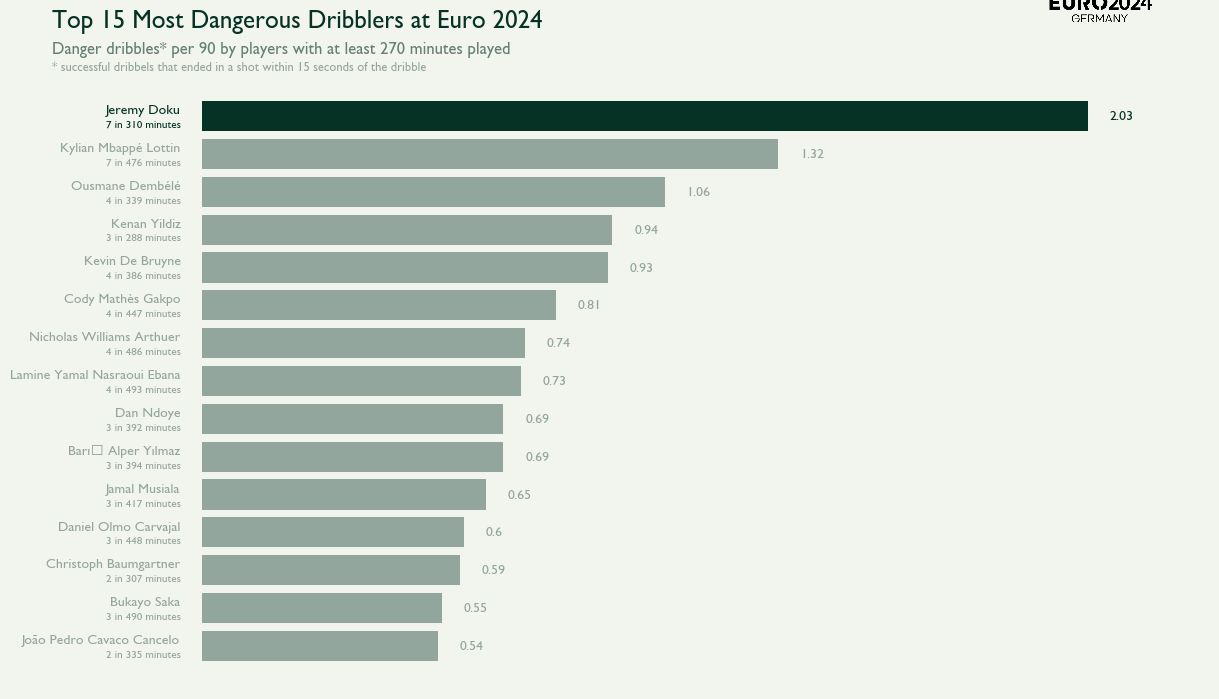

In [193]:
# Take top 15 players
df_danger_player_stats = df_danger_player_stats.sort_values('danger_dribbles_per_90', ascending=True).tail(15).reset_index(drop=True)

# Variables
background_color = "#f2f4ee"
dark_color = "#053225"

# Init plot
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor(background_color)
ax.set_facecolor(background_color)
plt.rcParams['font.family'] = 'Gill Sans'
plt.rcParams.update({
    'text.color': dark_color,
    'axes.labelcolor': dark_color,
    'axes.edgecolor': dark_color,
    'xtick.color': dark_color,
    'ytick.color': dark_color,
    'grid.color': dark_color,
})

# Set titles
plt.suptitle('Top 15 Most Dangerous Dribblers at Euro 2024', fontweight='bold', fontsize=18, ha='left', x=0, y=0.96)
plt.text(0, 0.9, 'Danger dribbles* per 90 by players with at least 270 minutes played', ha='left', va='bottom', transform=plt.gcf().transFigure, fontsize=12, color=dark_color, alpha=0.6)
plt.text(0, 0.88, '* successful dribbels that ended in a shot within 15 seconds of the dribble', ha='left', va='bottom', transform=plt.gcf().transFigure, fontsize=9, color=dark_color, alpha=0.4)

# Loop through data and plot different things
for i, row in df_danger_player_stats.iterrows():
    # Check if player is Jeremy Doku and set opacity accordingly
    player = row['player_name']
    alpha = 1.0 if player == 'Jeremy Doku' else 0.4 

    # Danger dribbles per 90 bar
    ax.barh(
        player,
        row['danger_dribbles_per_90'],
        color=dark_color,
        alpha=alpha
    )
    
    # Per 90 number
    per_90 = row['danger_dribbles_per_90']
    plt.text(per_90 + 0.05, i, per_90, va='center', fontweight='bold', alpha=alpha, color=dark_color)

    # Player name in bold
    ax.text(-0.05, i,
            f"{row['player_name']}", 
            ha='right',
            va='bottom',
            fontsize=10,
            fontweight='bold',
            alpha=alpha)
    
    # Team name in smaller, lighter font
    ax.text(-0.05, i - 0.1,
            f"{row['danger_dribbles']} in {row['minutes_played']:.0f} minutes", 
            ha='right',
            va='top',
            fontsize=8,
            alpha=alpha)
    

# Remove labels and ticks
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticks([])

# Remove all spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add Euros 2024 logo (moved to correct position on saved image, looks different here)
logo = mpimg.imread('euro_2024_logo.png')
imagebox = OffsetImage(logo, zoom=0.15)  # Adjust zoom factor as needed
ab = AnnotationBbox(imagebox, 
                    xy=(0.96, 0.91),      # Position in axes coordinates (x, y)
                    xycoords='figure fraction',
                    box_alignment=(1, 1),  # Alignment of box (1,1 is top right)
                    frameon=False)        # No frame around the image

fig.add_artist(ab)

# Adjust layout and margins
plt.savefig('danger_dribbles_per_90.png', 
            bbox_inches='tight',
            pad_inches=0.4,  # Adjust this value to control the padding
            facecolor=background_color,
            dpi=300)
plt.show()

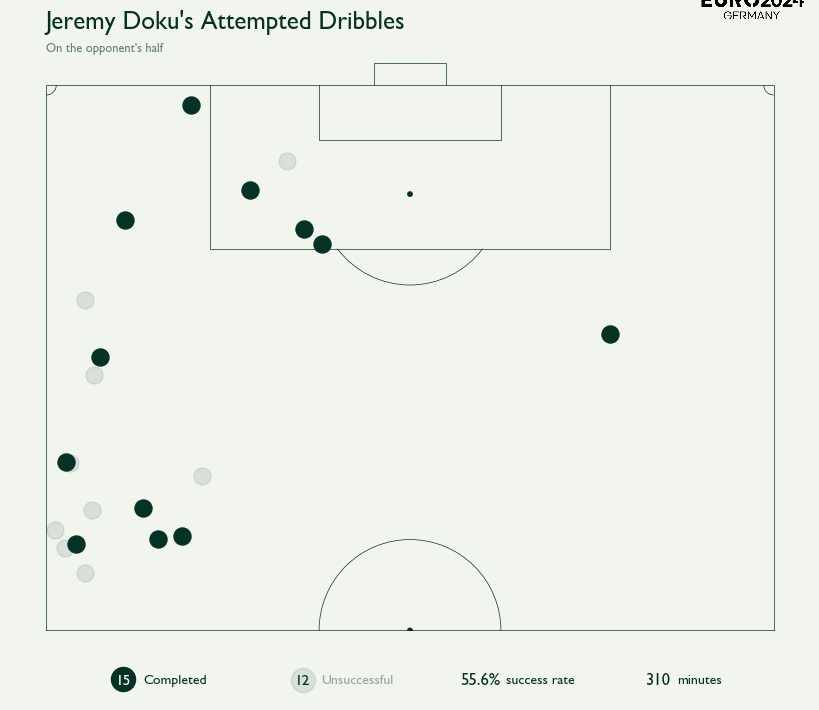

In [704]:
# Get Doku's dribbles
doku_dribbles = df_dribbles[df_dribbles['player_name'] == 'Jeremy Doku'].reset_index(drop=True)

# Get Doku's stats
doku_stats = df_player_stats[df_player_stats['player_name'] == 'Jeremy Doku'].reset_index(drop=True)

# Variables
background_color = "#f2f4ee"
dark_color = "#053225"

# Create figure first
fig = plt.figure(figsize=(10, 8))

# Create two axes - one for pitch, one for legend
pitch_ax = fig.add_axes([0.1, 0.2, 0.8, 0.8])  # [left, bottom, width, height]
legend_ax = fig.add_axes([0.15, 0.15, 0.7, 0.05])  # Smaller axes below for legend

# Create pitch on the main axes
pitch = VerticalPitch(
    line_color=dark_color, 
    linewidth=0.5, 
    half=True, 
    goal_type='box', 
    corner_arcs=True,
    pad_bottom=0.1
)
pitch.draw(ax=pitch_ax)
pitch_ax.set_facecolor(background_color)

# Set figure background
fig.set_facecolor(background_color)

# Style settings
plt.rcParams['font.family'] = 'Gill Sans'
plt.rcParams.update({
    'text.color': dark_color,
    'axes.labelcolor': dark_color,
    'axes.edgecolor': dark_color,
    'xtick.color': dark_color,
    'ytick.color': dark_color,
    'grid.color': dark_color,
})

# Add title
pitch_ax.set_title('Jeremy Doku\'s Attempted Dribbles', fontweight='bold', fontsize=18, ha='left', x=0.045, y=1.02)
pitch_ax.text(0.045, 0.99, 'On the opponent\'s half', ha='left', va='bottom', transform=pitch_ax.transAxes, fontsize=9, color=dark_color, alpha=0.6)

# Add Euros 2024 logo
logo = mpimg.imread('euro_2024_logo.png')
imagebox = OffsetImage(logo, zoom=0.15)
ab = AnnotationBbox(imagebox, 
                    xy=(0.7, 0.86),
                    xycoords='figure fraction',
                    box_alignment=(0, 0),
                    frameon=False)
fig.add_artist(ab)

# Plot dribbles on pitch_ax
for i, row in doku_dribbles.iterrows():
    if row['outcome_name'] == 'Complete':
        pitch.scatter(row['x'], row['y'], c=dark_color, s=150, ax=pitch_ax)
    else:
        pitch.scatter(row['x'], row['y'], c=dark_color, s=150, ax=pitch_ax, alpha=0.1)

# Add legend in legend_ax
x_start = 0.0505
y_position = 0.475
x_gap = 0.28

legend_ax.scatter(0, 0, c=dark_color, s=400, alpha=0)
legend_ax.scatter(0.0495, 0.52, c=dark_color, s=300) # Completed dribbles
legend_ax.scatter(0.332, 0.51, c=dark_color, s=300, alpha=0.1) # Unsuccessful dribbles
legend_ax.scatter(1, 1, c=dark_color, s=400, alpha=0)

# Completed dribbles
legend_ax.text(x_start - 0.001, y_position, doku_stats['complete_dribbles'][0], va='center', ha='center', fontsize=11, color='white', fontweight='bold')
legend_ax.text(x_start + 0.03, y_position, 'Completed', va='center', ha='left', fontsize=10, color=dark_color, fontweight='bold')

# Unsuccessful dribbles
legend_ax.text(x_start + x_gap, y_position, doku_stats['incomplete_dribbles'][0], va='center', ha='center', fontsize=11, color=dark_color, fontweight='bold')
legend_ax.text(x_start + x_gap + 0.03, y_position, 'Unsuccessful', va='center', ha='left', fontsize=10, color=dark_color, fontweight='bold', alpha=0.4)

# Success rate
legend_ax.text(x_start + (x_gap * 2), y_position, f"{doku_stats['dribble_success_rate'][0].round(1)}%", va='center', ha='center', fontsize=12, color=dark_color, fontweight='bold')
legend_ax.text(x_start + (x_gap * 2) + 0.04, y_position - 0.001, 'success rate', va='center', ha='left', fontsize=10, color=dark_color, fontweight='bold')

# Minutes
legend_ax.text(x_start + (x_gap * 3), y_position, doku_stats['minutes_played'][0].round(0).astype(int), va='center', ha='center', fontsize=12, color=dark_color, fontweight='bold')
legend_ax.text(x_start + (x_gap * 3) + 0.03, y_position - 0.001, 'minutes', va='center', ha='left', fontsize=10, color=dark_color, fontweight='bold')

# Remove axes from legend
legend_ax.set_xticks([])
legend_ax.set_yticks([])
legend_ax.set_frame_on(False)

# Save figure
plt.savefig('doku_dribbles.png', 
            bbox_inches='tight',
            pad_inches=0.4,
            facecolor=background_color,
            dpi=300)
plt.show()

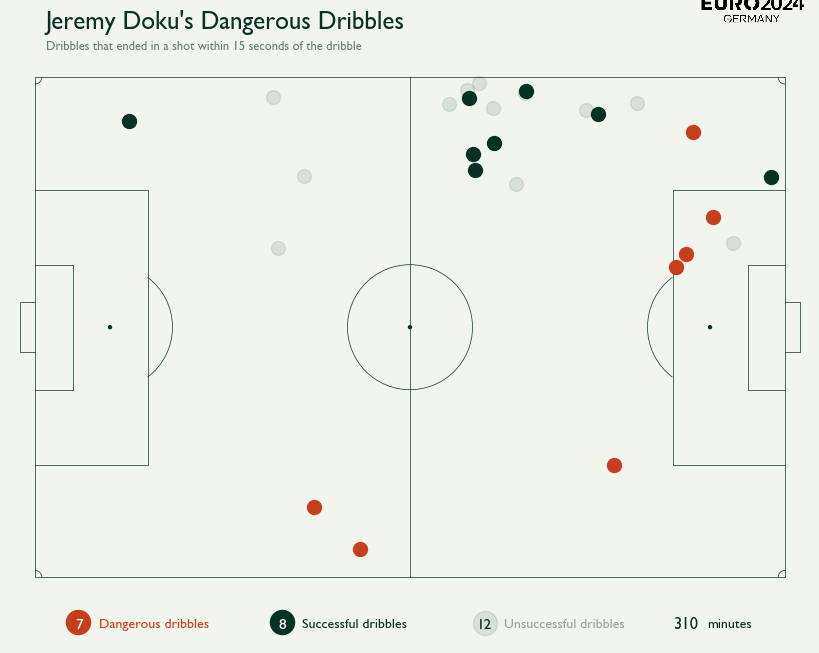

In [705]:
# Get Doku's danger dribbles
doku_danger_dribbles = danger_dribbles[danger_dribbles['player_name'] == 'Jeremy Doku']

# Exclude Doku's danger dribbles from doku_dribbles
filtered_doku_dribbles = doku_dribbles[~doku_dribbles.apply(tuple, 1).isin(doku_danger_dribbles.apply(tuple, 1))]

# Get Doku's danger stats
doku_danger_stats = df_danger_player_stats[df_danger_player_stats['player_name'] == 'Jeremy Doku'].reset_index(drop=True)
doku_stats = df_player_stats[df_player_stats['player_name'] == 'Jeremy Doku']

# Variables
background_color = "#f2f4ee"
dark_color = "#053225"
danger_color = "#C73E1D"

# Create figure first
fig = plt.figure(figsize=(10, 8))

# Create two axes - one for pitch, one for legend
pitch_ax = fig.add_axes([0.1, 0.2, 0.8, 0.8])  # [left, bottom, width, height]
legend_ax = fig.add_axes([0.135, 0.19, 0.73, 0.05])  # Smaller axes below for legend

# Create pitch on the main axes
pitch = Pitch(
    line_color=dark_color, 
    linewidth=0.5, 
    half=False, 
    goal_type='box', 
    corner_arcs=True,
    pad_bottom=0.1
)
pitch.draw(ax=pitch_ax)
pitch_ax.set_facecolor(background_color)

# Set figure background
fig.set_facecolor(background_color)

# Style settings
plt.rcParams['font.family'] = 'Gill Sans'
plt.rcParams.update({
    'text.color': dark_color,
    'axes.labelcolor': dark_color,
    'axes.edgecolor': dark_color,
    'xtick.color': dark_color,
    'ytick.color': dark_color,
    'grid.color': dark_color,
})

# Add title and subtitle
pitch_ax.set_title('Jeremy Doku\'s Dangerous Dribbles', fontweight='bold', fontsize=18, ha='left', x=0.045, y=1.03)
pitch_ax.text(0.045, 1, 'Dribbles that ended in a shot within 15 seconds of the dribble', ha='left', va='bottom', transform=pitch_ax.transAxes, fontsize=9, color=dark_color, alpha=0.6)

# Add Euros 2024 logo
logo = mpimg.imread('euro_2024_logo.png')
imagebox = OffsetImage(logo, zoom=0.15)
ab = AnnotationBbox(imagebox, 
                    xy=(0.7, 0.785),
                    xycoords='figure fraction',
                    box_alignment=(0, 0),
                    frameon=False)
fig.add_artist(ab)

# Plot filtered dribbles on pitch
for i, row in filtered_doku_dribbles.iterrows():
    if row['outcome_name'] == 'Complete':
        pitch.scatter(row['x'], row['y'], c=dark_color, s=100, ax=pitch_ax)
    else:
        pitch.scatter(row['x'], row['y'], c=dark_color, s=100, ax=pitch_ax, alpha=0.1)

# Plot danger dribbles on pitch
for i, row in doku_danger_dribbles.iterrows():
    pitch.scatter(row['x'], row['y'], c=danger_color, s=100, ax=pitch_ax)

# Add legend in legend_ax
x_start = 0.002
y_position = 0.46
x_gap = 0.305

legend_ax.scatter(0, 0, c=dark_color, s=400, alpha=0)
legend_ax.scatter(0, 0.52, c=danger_color, s=300) # Dangerous dribbles
legend_ax.scatter(0.3065, 0.52, c=dark_color, s=300) # Completed dribbles
legend_ax.scatter(0.613, 0.5, c=dark_color, s=300, alpha=0.1) # Unsuccessful dribbles
legend_ax.scatter(1, 1, c=dark_color, s=400, alpha=0)

# Dangerous dribbles
legend_ax.text(x_start - 0.001, y_position, doku_danger_stats['danger_dribbles'][0], va='center', ha='center', fontsize=11, color='white', fontweight='bold')
legend_ax.text(x_start + 0.03, y_position, 'Dangerous dribbles', va='center', ha='left', fontsize=10, color=danger_color, fontweight='bold')

# Completed dribbles
completed_dribbles = len(filtered_doku_dribbles[filtered_doku_dribbles['outcome_name'] == 'Complete'])
legend_ax.text(x_start + x_gap, y_position, completed_dribbles, va='center', ha='center', fontsize=11, color='white', fontweight='bold')
legend_ax.text(x_start + x_gap + 0.03, y_position, 'Successful dribbles', va='center', ha='left', fontsize=10, color=dark_color, fontweight='bold')

# Unsuccessful dribbles
incomplete_dribbles = len(filtered_doku_dribbles[filtered_doku_dribbles['outcome_name'] == 'Incomplete'])
legend_ax.text(x_start + (x_gap * 2), y_position, incomplete_dribbles, va='center', ha='center', fontsize=11, color=dark_color, fontweight='bold')
legend_ax.text(x_start + (x_gap * 2) + 0.03, y_position, 'Unsuccessful dribbles', va='center', ha='left', fontsize=10, color=dark_color, fontweight='bold', alpha=0.4)

# Minutes
legend_ax.text(x_start + (x_gap * 3), y_position, doku_stats['minutes_played'][0].round(0).astype(int), va='center', ha='center', fontsize=12, color=dark_color, fontweight='bold')
legend_ax.text(x_start + (x_gap * 3) + 0.03, y_position - 0.001, 'minutes', va='center', ha='left', fontsize=10, color=dark_color, fontweight='bold')

# Remove axes from legend
legend_ax.set_xticks([])
legend_ax.set_yticks([])
legend_ax.set_frame_on(False)

# Save figure
plt.savefig('doku_danger_dribbles.png', 
            bbox_inches='tight',
            pad_inches=0.4,
            facecolor=background_color,
            dpi=300)
plt.show()

In [652]:
doku_danger_dribbles.head(10)

,match_id,period,minute,second,type_name,team_name,player_name,outcome_name,x,y
29,3938645,2,72,39,Dribble,Belgium,Jeremy Doku,Complete,108.5,22.4
30,3938645,2,72,40,Dribble,Belgium,Jeremy Doku,Complete,104.2,28.3
87,3930164,1,2,3,Dribble,Belgium,Jeremy Doku,Complete,44.7,68.8
88,3930164,1,2,4,Dribble,Belgium,Jeremy Doku,Complete,52.0,75.5
89,3930164,1,2,10,Dribble,Belgium,Jeremy Doku,Complete,92.6,62.0
91,3930164,2,61,46,Dribble,Belgium,Jeremy Doku,Complete,105.2,8.7
128,3930175,2,62,0,Dribble,Belgium,Jeremy Doku,Complete,102.5,30.3
